In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import numpy as np
import math
import pandas as pd
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization  # Updated import here
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
!pip install rarfile
import rarfile
import os

# extract our rar file
with rarfile.RarFile("/content/drive/MyDrive/ai model/30foodsdata.rar", 'r') as rf:
    rf.extractall()

In [4]:
import shutil
# Move the train folder to the Ai model folder
source_dir = "/content/train"

destination_dir = "/content/drive/MyDrive/ai model"

os.makedirs(destination_dir, exist_ok=True)

shutil.move(source_dir, destination_dir)

print("Train folder moved successfully to:", destination_dir)


Train folder moved successfully to: /content/drive/MyDrive/ai model


In [5]:
import random
#move 200 images of each food from train to test folder
train_folder = "/content/drive/MyDrive/ai model/train"
test_folder = "/content/drive/MyDrive/ai model/test"

num_images_to_move = 200


for food_folder in os.listdir(train_folder):
    food_folder_path = os.path.join(train_folder, food_folder)
    if os.path.isdir(food_folder_path):
        images = [f for f in os.listdir(food_folder_path) if os.path.isfile(os.path.join(food_folder_path, f))]
        images_to_move = random.sample(images, min(num_images_to_move, len(images)))
        test_food_folder_path = os.path.join(test_folder, food_folder)
        os.makedirs(test_food_folder_path, exist_ok=True)

        for image in images_to_move:
            src = os.path.join(food_folder_path, image)
            dst = os.path.join(test_food_folder_path, image)
            shutil.move(src, dst)
            print(f"Moved {image} to {test_food_folder_path}")

print("Finished moving images to the test folder.")


Streaming output truncated to the last 5000 lines.
Moved 1900399.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 1820233.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 136841.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 1073755.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 2367129.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 1167275.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 2248367.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 2048548.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 1844533.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 3220324.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 191378.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 2538603.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 2293386.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 800732.jpg to /content/drive/MyDrive/ai model/test/donuts
Moved 1765.jpg to /content/drive/MyDrive/a

In [2]:
train_dir = "train"
test_dir = "test"

In [3]:
image_size=224
learning_rate=0.001
batch_size=32

In [4]:
directory_path = 'train'

# Function to get file formats from a directory
def get_file_formats(directory_path):
    file_formats = set()
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            _, ext = os.path.splitext(file)
            file_formats.add(ext)
    return file_formats

# Get the set of file formats
file_formats = get_file_formats(directory_path)

# Print the file formats
for format in file_formats:
    print(format)

.jpg


In [5]:
training_folder_path = "train"
training_set="train"
labels = [label for label in os.listdir(training_folder_path) if os.path.isdir(os.path.join(training_folder_path, label))]

# Sort the labels alphabetically
sorted_labels = sorted(labels)

print("Sorted Labels:")
for label in sorted_labels:
    print(label)

Sorted Labels:
apple_pie
beef_tartare
cannoli
churros
cup_cakes
deviled_eggs
donuts
dumplings
edamame
french_fries
fried_rice
garlic_bread
gnocchi
greek_salad
gyoza
hamburger
hot_and_sour_soup
hot_dog
ice_cream
mussels
onion_rings
oysters
pancakes
pizza
ramen
samosa
sashimi
spring_rolls
sushi
waffles


In [6]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_set,
    seed=42,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=32
)

Found 24000 files belonging to 30 classes.


In [7]:
tr_class_names = train_dataset.class_names
tr_class_names

['apple_pie',
 'beef_tartare',
 'cannoli',
 'churros',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'french_fries',
 'fried_rice',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'ice_cream',
 'mussels',
 'onion_rings',
 'oysters',
 'pancakes',
 'pizza',
 'ramen',
 'samosa',
 'sashimi',
 'spring_rolls',
 'sushi',
 'waffles']

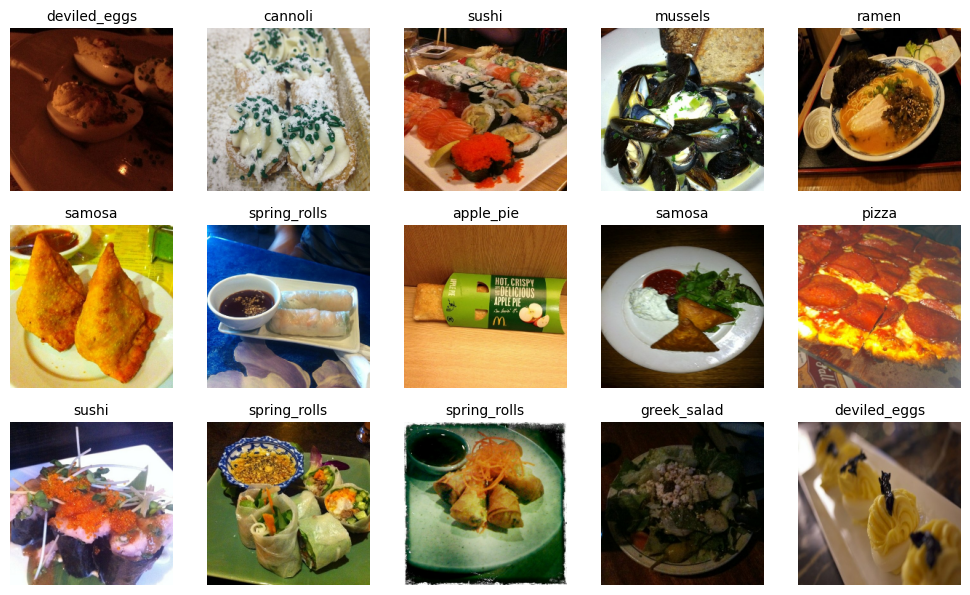

In [21]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5,5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(tr_class_names[labels_batch[i]], fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=1234)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)

    return train_ds, val_ds

In [23]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [27]:
# Define preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Preprocess and augment data
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
channels=3
input_shape = (batch_size, image_size, image_size, channels)

# Number of outputs
n_classes = len(tr_class_names)
n_classes

30

In [32]:
# Defining preprocessing layers
preprocessing_layers = Sequential([
    resize_and_rescale,
    data_augmentation
])

In [68]:
model = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)), #enchane features by compressing pixels

    layers.Conv2D(28, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size =(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [69]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_61 (Conv2D)          (32, 222, 222, 16)        448       
                                                                 
 max_pooling2d_61 (MaxPooli  (32, 111, 111, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (32, 109, 109, 28)        4060      
                                                                 
 max_pooling2d_62 (MaxPooli  (32, 54, 54, 28)          0         
 ng2D)                                               

In [70]:
#Compile the model
model.compile(loss = "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [124]:
history = model.fit(
    train_ds,
    epochs=20,
    batch_size=BATCH_size,
    validation_data=val_ds
)

Epoch 1/20
344/344 [==============================] - 120s 304ms/step - loss: 0.9196 - accuracy: 0.4789 - val_loss: 0.8282 - val_accuracy: 0.5058
Epoch 2/20
344/344 [==============================] - 91s 263ms/step - loss: 0.6705 - accuracy: 0.6846 - val_loss: 0.4258 - val_accuracy: 0.8430
Epoch 3/20
344/344 [==============================] - 82s 238ms/step - loss: 0.5106 - accuracy: 0.7674 - val_loss: 0.3715 - val_accuracy: 0.8488
Epoch 4/20
344/344 [==============================] - 83s 242ms/step - loss: 0.4503 - accuracy: 0.8096 - val_loss: 0.3325 - val_accuracy: 0.8837
Epoch 5/20
344/344 [==============================] - 82s 238ms/step - loss: 0.3873 - accuracy: 0.8365 - val_loss: 0.3696 - val_accuracy: 0.8198
Epoch 6/20
344/344 [==============================] - 85s 247ms/step - loss: 0.3464 - accuracy: 0.8445 - val_loss: 0.4476 - val_accuracy: 0.7674
Epoch 7/20
344/344 [==============================] - 84s 243ms/step - loss: 0.3313 - accuracy: 0.8597 - val_loss: 0.2636 - val_a

In [126]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

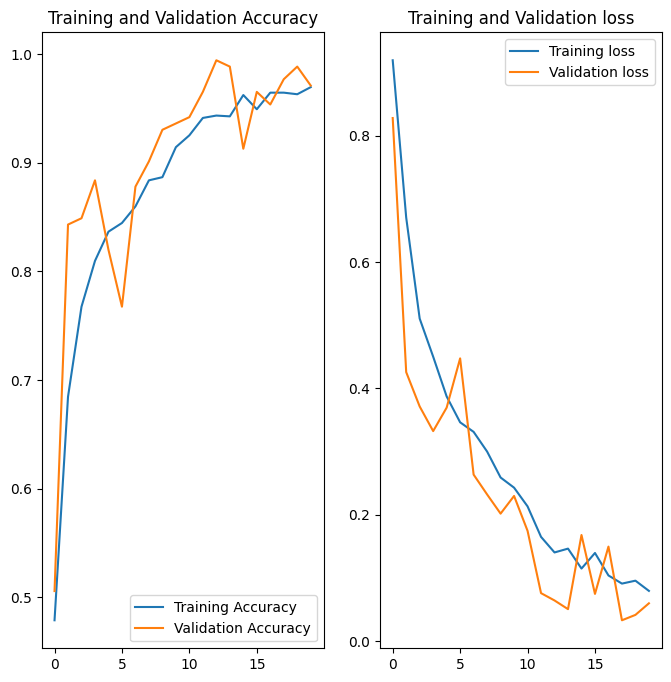

In [127]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(20),acc,label='Training Accuracy')
plt.plot(range(20),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(20),loss,label='Training loss')
plt.plot(range(20),val_loss,label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

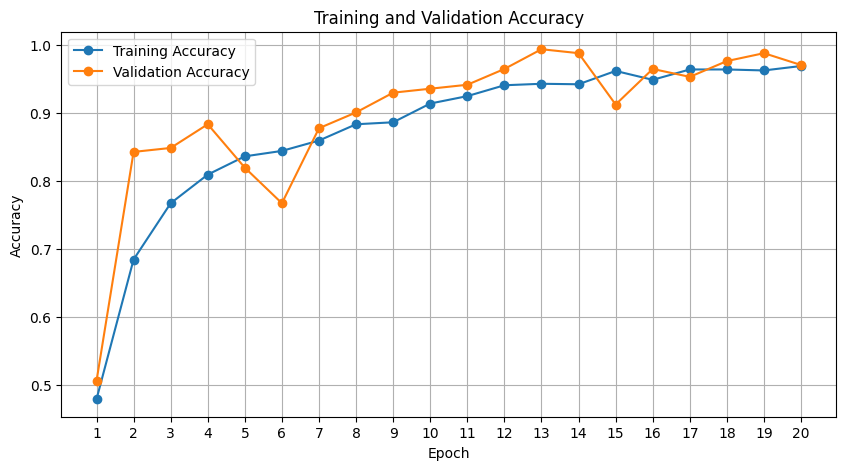

In [128]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy', marker='o')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(acc) + 1))
plt.legend()
plt.grid(True)
plt.show()

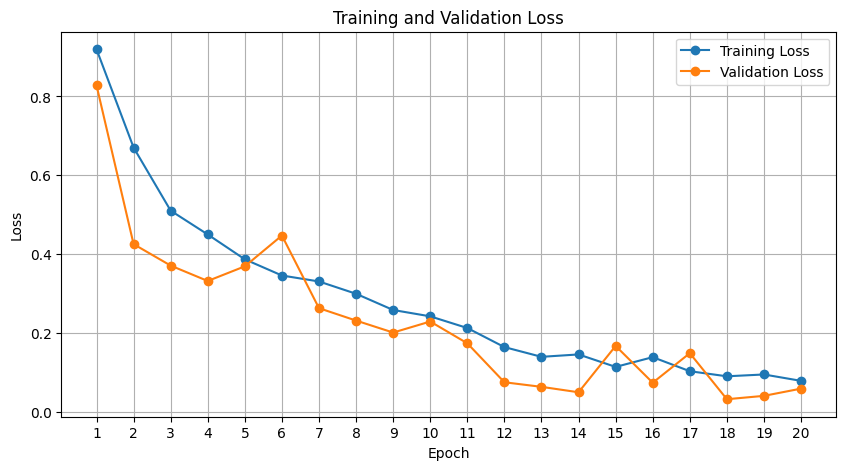

In [129]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(loss) + 1))
plt.legend()
plt.grid(True)
plt.show()

In [131]:
import pandas as pd
history_df = pd.DataFrame({
    'Epoch': range(1, len(acc) + 1),
    'Training Accuracy': acc,
    'Validation Accuracy': val_acc,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# Displaying the DataFrame
print(history_df)

    Epoch  Training Accuracy  Validation Accuracy  Training Loss  \
0       1           0.478924             0.505814       0.919604   
1       2           0.684593             0.843023       0.670545   
2       3           0.767442             0.848837       0.510621   
3       4           0.809593             0.883721       0.450303   
4       5           0.836483             0.819767       0.387349   
5       6           0.844477             0.767442       0.346360   
6       7           0.859738             0.877907       0.331252   
7       8           0.883721             0.901163       0.300085   
8       9           0.886628             0.930233       0.258983   
9      10           0.914244             0.936047       0.242901   
10     11           0.925145             0.941860       0.213315   
11     12           0.941134             0.965116       0.164990   
12     13           0.943314             0.994186       0.140344   
13     14           0.942587             0.98837

1/1 [==============================] - 0s 72ms/step


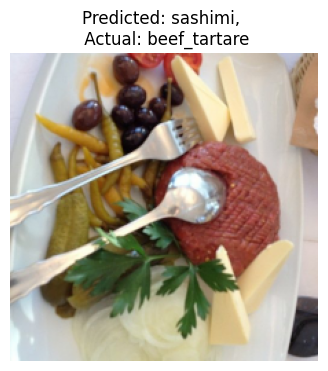

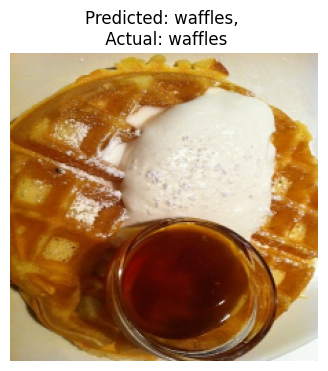

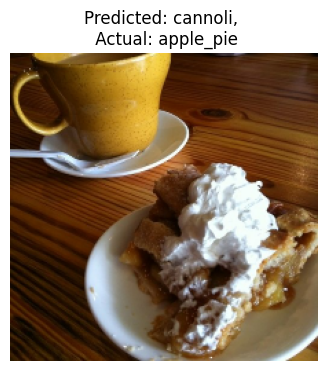

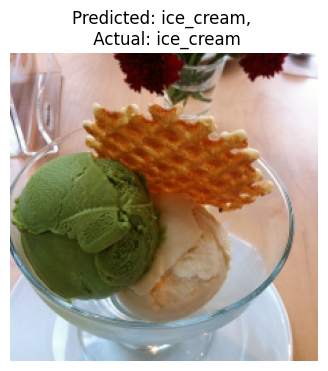

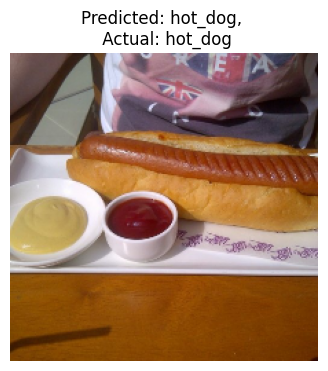

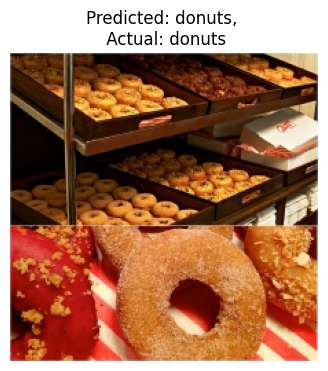

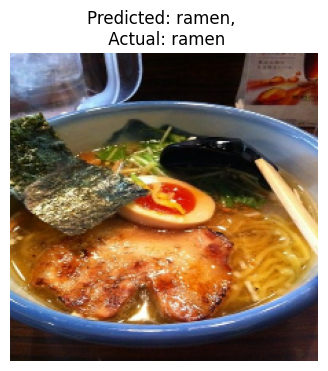

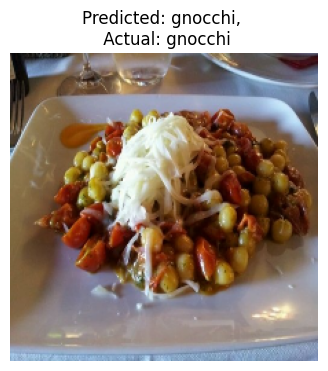

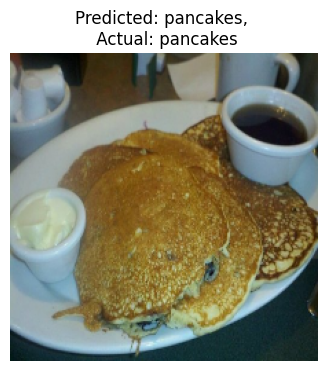

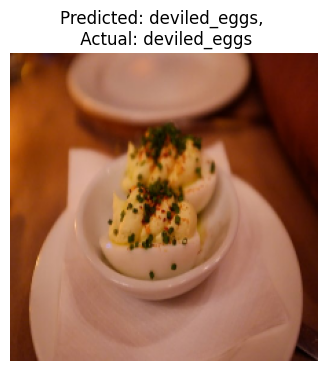

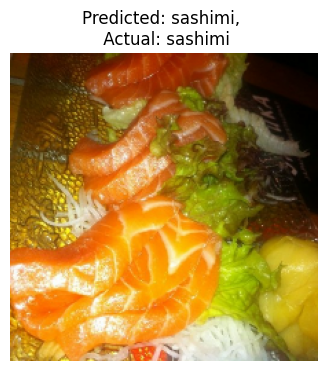

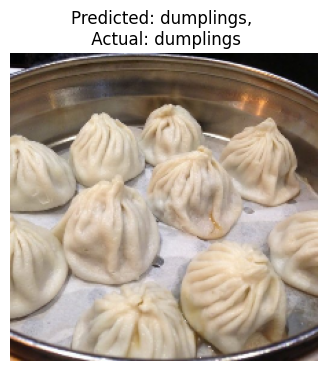

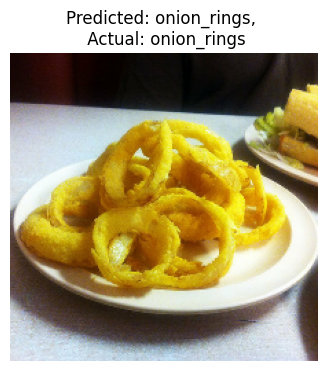

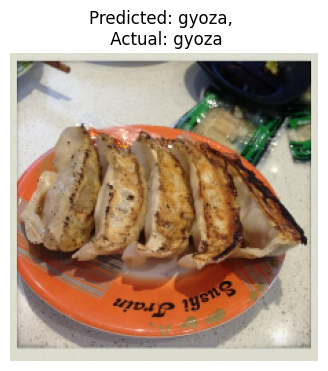

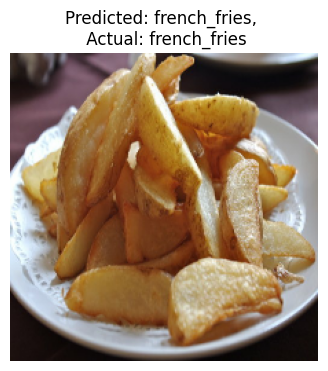

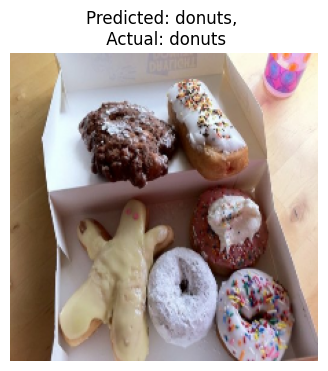

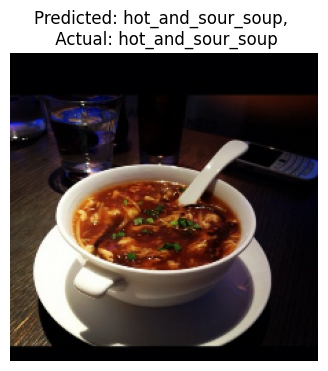

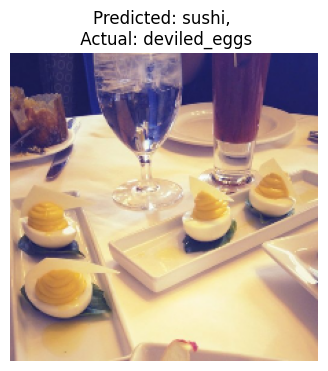

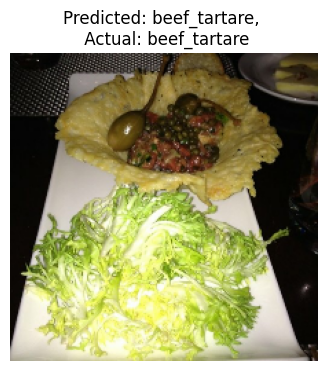

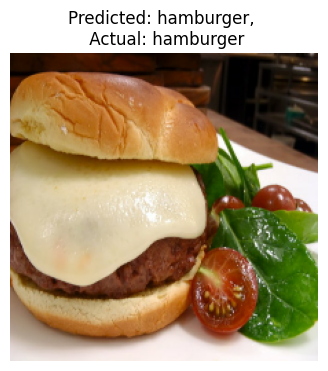

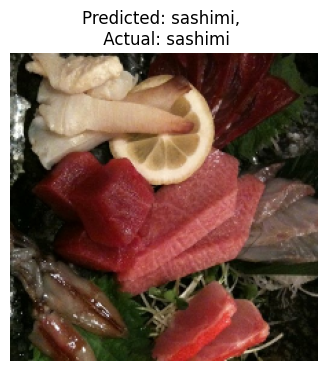

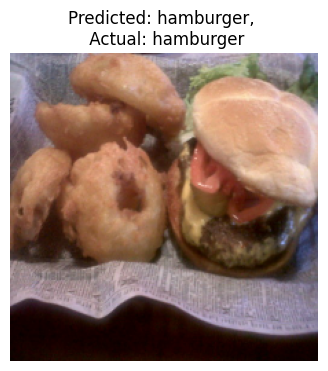

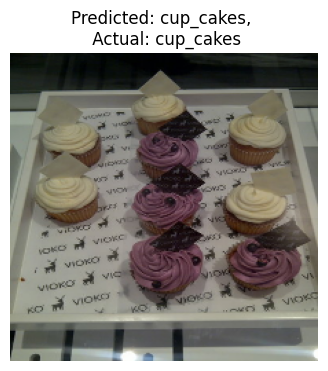

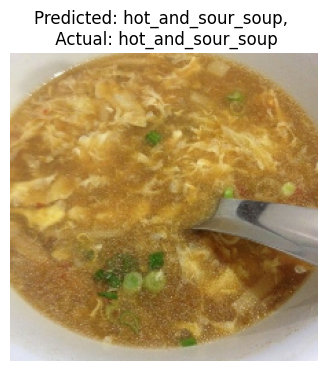

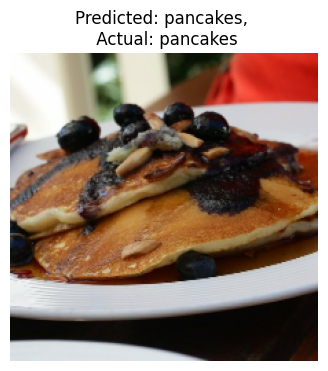

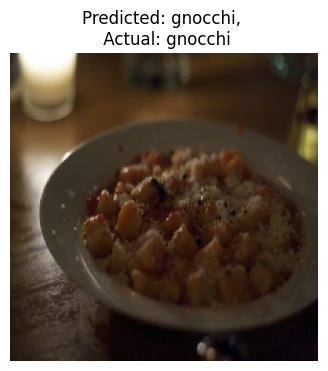

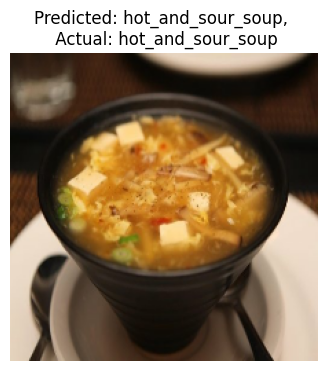

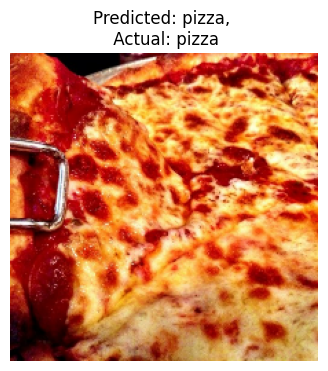

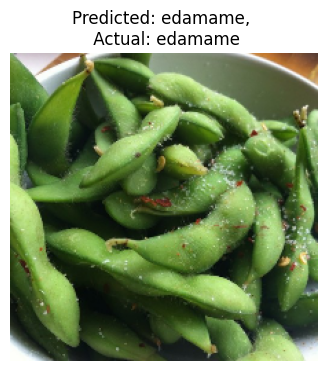

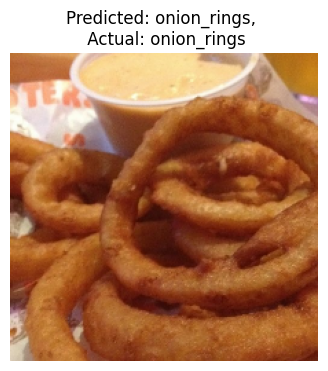

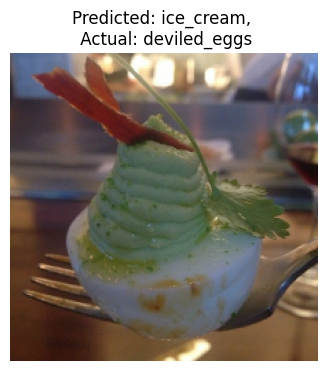

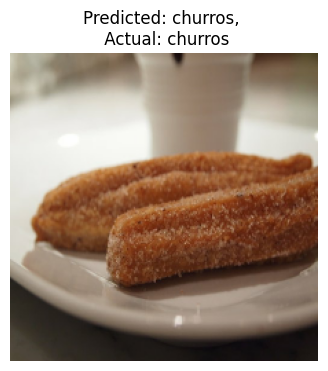

In [26]:
# Get class names from the training dataset
class_names = train_data.class_names

# Predict probabilities for images in the test dataset
predictions = model.predict(test_data)

# Get images and labels from the test dataset for visualization
for images, labels in test_data.take(1):  # Take one batch of images from the test dataset
    # Make predictions on the batch
    batch_predictions = model.predict(images)
    # Iterate over each image in the batch
    for i in range(len(images)):
        # Get the predicted class index (argmax of predictions)
        predicted_class_index = np.argmax(batch_predictions[i])
        # Get the predicted class name
        predicted_class_name = class_names[predicted_class_index]
        # Get the true class index
        true_class_index = np.argmax(labels[i])
        # Get the true class name
        true_class_name = class_names[true_class_index]

        # Plot the image with the predicted class name and true class name
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}, \n Actual: {true_class_name}")
        plt.axis('off')
        plt.show()

In [52]:
# Define the path where you want to save the model
model_save_path = "/content/drive/MyDrive/ai model/model"

# Save the model
model.save(model_save_path)


In [8]:
import tensorflow.keras.models as keras_models

# Load the saved model
loaded_model = keras_models.load_model("model")

# Print confirmation message
print("Model loaded successfully!")


Model loaded successfully!


In [56]:
import random
#move 200 images of each food from train to test folder
train_folder = "train"
test_folder = "test"

num_images_to_move = 200


for food_folder in os.listdir(train_folder):
    food_folder_path = os.path.join(train_folder, food_folder)
    if os.path.isdir(food_folder_path):
        images = [f for f in os.listdir(food_folder_path) if os.path.isfile(os.path.join(food_folder_path, f))]
        images_to_move = random.sample(images, min(num_images_to_move, len(images)))
        test_food_folder_path = os.path.join(test_folder, food_folder)
        os.makedirs(test_food_folder_path, exist_ok=True)

        for image in images_to_move:
            src = os.path.join(food_folder_path, image)
            dst = os.path.join(test_food_folder_path, image)
            shutil.move(src, dst)
            print(f"Moved {image} to {test_food_folder_path}")

print("Finished moving images to the test folder.")


Moved 3068872.jpg to test\apple_pie
Moved 2074865.jpg to test\apple_pie
Moved 794735.jpg to test\apple_pie
Moved 208041.jpg to test\apple_pie
Moved 1072416.jpg to test\apple_pie
Moved 2610524.jpg to test\apple_pie
Moved 3021995.jpg to test\apple_pie
Moved 1586889.jpg to test\apple_pie
Moved 1510125.jpg to test\apple_pie
Moved 649621.jpg to test\apple_pie
Moved 2068700.jpg to test\apple_pie
Moved 813881.jpg to test\apple_pie
Moved 2605751.jpg to test\apple_pie
Moved 2510497.jpg to test\apple_pie
Moved 597533.jpg to test\apple_pie
Moved 300660.jpg to test\apple_pie
Moved 2724897.jpg to test\apple_pie
Moved 2245633.jpg to test\apple_pie
Moved 1931301.jpg to test\apple_pie
Moved 2440054.jpg to test\apple_pie
Moved 910333.jpg to test\apple_pie
Moved 2769470.jpg to test\apple_pie
Moved 2223847.jpg to test\apple_pie
Moved 1088809.jpg to test\apple_pie
Moved 3687109.jpg to test\apple_pie
Moved 2446500.jpg to test\apple_pie
Moved 2369640.jpg to test\apple_pie
Moved 3720779.jpg to test\apple_pie

In [9]:
import tensorflow.keras.preprocessing as tfprep
# Load the test dataset
test_data = tfprep.image_dataset_from_directory(test_dir,batch_size=32,image_size=(224,224),label_mode="categorical")

# Evaluate the loaded model on the test dataset
loss, accuracy = loaded_model.evaluate(test_data)

# Print the accuracy
print(f"Accuracy on the test dataset: {accuracy}")

Found 6000 files belonging to 30 classes.
188/188 [==============================] - 544s 3s/step - loss: 0.2819 - accuracy: 0.9270
Accuracy on the test dataset: 0.9269999861717224


In [9]:
# Get class names from the training dataset
class_names = train_dataset.class_names

# Predict probabilities for images in the test dataset
predictions = loaded_model.predict(test_data)

# Get images and labels from the test dataset for visualization
for images, labels in test_data.take(1):  # Take one batch of images from the test dataset
    # Make predictions on the batch
    batch_predictions = loaded_model.predict(images)
    # Iterate over each image in the batch
    for i in range(len(images)):
        # Get the predicted class index (argmax of predictions)
        predicted_class_index = np.argmax(batch_predictions[i])
        # Get the predicted class name
        predicted_class_name = class_names[predicted_class_index]
        # Get the true class index
        true_class_index = np.argmax(labels[i])
        # Get the true class name
        true_class_name = class_names[true_class_index]

        # Plot the image with the predicted class name and true class name
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_class_name}, Actual: {true_class_name}")
        plt.axis('off')
        plt.show()


NameError: name 'test_data' is not defined

1/1 [==============================] - 0s 150ms/step


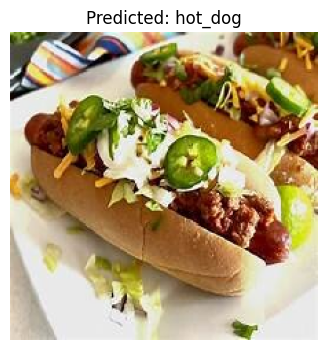

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
class_names = train_dataset.class_names

# Function to preprocess a single image
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

image_path = "img01.jpg"

preprocessed_image = preprocess_image(image_path)

predictions = loaded_model.predict(preprocessed_image)

predicted_class_index = np.argmax(predictions[0])

predicted_class_name = class_names[predicted_class_index]

image_to_plot = preprocessed_image[0].numpy().astype("uint8")

plt.figure(figsize=(4, 4))
plt.imshow(image_to_plot)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()


In [13]:
food = predicted_class_name
import pandas as pd

# Load the recipes data from the CSV file
recipes_df = pd.read_csv("recipe.csv")

In [14]:
predicted_food_row = recipes_df[recipes_df['Foods'] == predicted_class_name]

In [15]:
if not predicted_food_row.empty:
    # Get the ingredients and recipe for the predicted food
    predicted_food_ingredients = predicted_food_row.iloc[0]['Ingredients']
    predicted_food_recipe = predicted_food_row.iloc[0]['Instructions']
    print("\nPredicted Food:", predicted_class_name)
    print("\nIngredients:", predicted_food_ingredients)
    print("\nRecipe:")
    print(predicted_food_recipe)
else:
    print("No recipe found for the predicted food:", predicted_class_name)


Predicted Food: hot_and_sour_soup

Ingredients: 6 cups chicken broth
1/4 cup soy sauce
1/4 cup rice vinegar
2 tablespoons cornstarch
2 eggs, lightly beaten
8 ounces tofu, diced
1 cup sliced mushrooms
1/2 cup bamboo shoots, sliced
1/4 cup sliced green onions
1 teaspoon chili paste or Sriracha (adjust to taste)
Salt and pepper to taste

Recipe:
In a large pot, combine the chicken broth, soy sauce, and rice vinegar. Bring to a boil over medium-high heat.
In a small bowl, mix the cornstarch with a few tablespoons of water to create a slurry. Slowly pour the slurry into the boiling broth, stirring constantly, until the soup thickens slightly.
Reduce the heat to medium-low and add the tofu, mushrooms, bamboo shoots, and green onions to the pot. Simmer for 5-7 minutes, or until the vegetables are tender.
Slowly drizzle the beaten eggs into the soup while stirring gently with a fork to create egg ribbons.
Add the chili paste or Sriracha, and season with salt and pepper to taste.
Serve hot, ga